In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Comparing current processor performance to the latest calibration data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/compare_to_calibration"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/google/compare_to_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/google/compare_to_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/compare_to_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

Calibration runs at periodic intervals, but processor performances changes over time. How does the current state of a processor compare to the latest calibration data? This tutorial shows how to run a Loschmidt echo and parallel XEB experiment to compare current two-qubit gate errors to the most recent calibration report.

**Disclaimer**: The data shown in this tutorial is exemplary and not representative of the QCS in production.

## Setup

First, we install Cirq and import the packages we will use.

In [3]:
try:
    import cirq
except ImportError:
    !pip install cirq --pre --quiet

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import cirq
import cirq_google as cg

Next, we authorize to use the Quantum Computing Service.

In [5]:
# The Google Cloud Project id to use.
project_id = '' #@param {type:"string"}

if project_id == '':
    import os 
    if 'GOOGLE_CLOUD_PROJECT' not in os.environ:
        raise Exception("Please setup project_id in this cell or set the `GOOGLE_CLOUD_PROJECT` env var to your project id.")
    project_id = os.environ['GOOGLE_CLOUD_PROJECT']
else: 
    import os
    os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

def authenticate_user():
    """Runs the user through the Colab OAuth process.

    Checks for Google Application Default Credentials and runs interactive login 
    if the notebook is executed in Colab. In case the notebook is executed in Jupyter notebook
    or other IPython runtimes, no interactive login is provided, it is assumed that the 
    `GOOGLE_APPLICATION_CREDENTIALS` env var is set or `gcloud auth application-default login`
    was executed already.

    For more information on using Application Default Credentials see 
    https://cloud.google.com/docs/authentication/production
    """
    in_colab = False
    try:
        from IPython import get_ipython
        in_colab = 'google.colab' in str(get_ipython())
    except: 
        # Notebook is not executed within IPython. Assuming external authentication.
        return 

    if in_colab: 
        from google.colab import auth      
        print("Getting OAuth2 credentials.")
        print("Press enter after entering the verification code.")
        auth.authenticate_user(clear_output=False)
        print("Authentication complete.")
    else: 
        print("Notebook is not executed with Colab, assuming Application Default Credentials are setup.") 

authenticate_user()

print("Successful authentication to Google Cloud.")

Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.
Successful authentication to Google Cloud.


Now, we select a processor and several line segments on the processor.

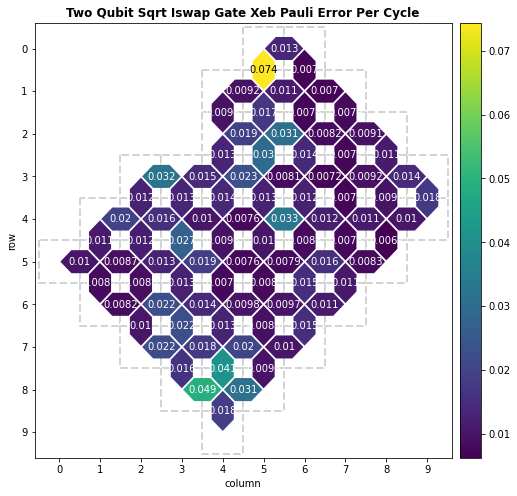

In [6]:
processor_id = "" #@param {type:"string"}
calibration = cg.get_engine_calibration(processor_id=processor_id)
metric = "two_qubit_sqrt_iswap_gate_xeb_pauli_error_per_cycle"

calibration.heatmap(metric).plot();

In [7]:
"""Select a line of qubits to form multiple line segments."""
line = [
    (1, 4), (1, 5), (1, 6), (1, 7), (2, 7), (3, 7), 
    (3, 6), (3, 5), (3, 4), (4, 4), (5, 4), (6, 4),
]
min_length = 6

max_length = len(line)
lines = [line[:min_length + i] for i in range(max_length - min_length + 1)]

# Convert indices to grid qubits.
all_qubits = [[cirq.GridQubit(*idx) for idx in l] for l in lines]

## Calibration

The following codeblock pulls the latest $\sqrt{\text{iSWAP}}$ XEB Pauli error per cycle from calibration. For more background on the calibration API and different metrics, see the [Calibration API tutorial](https://quantumai.google/cirq/tutorials/google/visualizing_calibration_metrics).


In [8]:
"""Average errors from calibration."""
cal = calibration.get(metric)

cvals = []
for qubits in all_qubits:
    error = 0.0
    for (q0, q1), cal_error in cal.items():
        if q0 in qubits and q1 in qubits:
            error += cal_error[0]

    cvals.append(error / len(qubits))

## Loschmidt echo

Now we run a Loschmidt echo experiment. For more background on this section, see the [Loschmidt echo tutorial](https://quantumai.google/cirq/tutorials/google/echoes).

In [9]:
#@title Helper functions
from typing import List, Optional, Sequence


def create_loschmidt_echo_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    seed: Optional[int] = None,
) -> cirq.Circuit:
    rng = np.random.RandomState(seed)
    oneq_gates = [cirq.PhasedXPowGate(phase_exponent=p, exponent=0.5)
                  for p in np.arange(-1.0, 1.0, 0.25)]

    # Forward (U) operations.
    circuit = cirq.Circuit()
    for i in range(cycles):
        # Layer of one-qubit gates.
        circuit.append(
            [rng.choice(oneq_gates).on(q) for q in qubits], 
            strategy=cirq.InsertStrategy.NEW_THEN_INLINE,
        )
        # Layer of two-qubit gates.
        circuit.append(
            [twoq_gate.on(qubits[j], qubits[j + 1]) for j in range(i % 2, len(qubits) - 1, 2)],
            strategy=cirq.InsertStrategy.NEW_THEN_INLINE,
        )

    return circuit + cirq.inverse(circuit) + cirq.measure(*qubits, key="z")


def to_ground_state_prob(result: cirq.Result) -> float:
    return np.mean(np.sum(result.measurements["z"], axis=1) == 0)

In [10]:
"""Run the Loschmidt echo experiment."""
cycle_values = range(0, 80 + 1, 2)
nreps = 20_000
trials = 5
sampler = cg.get_engine_sampler(
    project_id=project_id,
    processor_id=processor_id,
    gate_set_name="sqrt_iswap",
)


probs = []
for (i, qubits) in enumerate(all_qubits):
    print("\r", f"Status: On qubit set {i + 1} / {len(all_qubits)}", end="")

    # Create the batch of circuits.
    batch = [
        create_loschmidt_echo_circuit(qubits, cycles=c, seed=trial)
        for trial in range(trials) for c in cycle_values
    ]

    # Run the batch.
    try:
        results = sampler.run_batch(programs=batch, repetitions=nreps)
        probs.append([to_ground_state_prob(*res) for res in results])

    # Split into two batches if needed.
    except cg.engine.EngineException:
        res1 = sampler.run_batch(programs=batch[:len(batch) // 2], repetitions=nreps)
        res2 = sampler.run_batch(programs=batch[len(batch) // 2:], repetitions=nreps)

        probs.append(
            [to_ground_state_prob(*res) for res in res1] + 
            [to_ground_state_prob(*res) for res in res2]
        )

 Status: On qubit set 7 / 7

The next cell fits collected data (to be visualized) with an exponential curve. It also normalizes errors by the number of two-qubit gates per cycle (which is larger for circuits with more qubits).

In [11]:
"""Fit exponentials to the collected data."""
from scipy.optimize import curve_fit

def fit(cycle, a, f):
    return a * np.exp((f - 1.0) * cycle)


avg_probs = []
for (i, p) in enumerate(probs):
    p = np.array(p).reshape((trials, len(cycle_values)))
    avg_probs.append(np.average(p, axis=0))

opt_avals = []
opt_fvals = []
for (i, p) in enumerate(avg_probs):
    (a, f), _ = curve_fit(fit, xdata=cycle_values, ydata=p)

    opt_avals.append(a)
    opt_fvals.append(f)

# Normalize for number of two-qubit gates.
cycle_step = np.average(np.diff(cycle_values))
num_two_qubit_gates_per_cycle_step = []

for qubits in all_qubits:
    circuits = [create_loschmidt_echo_circuit(qubits, cycles=c) for c in cycle_values]
    diffs = np.diff(
        [sum([cirq.num_qubits(op) == 2 for op in circ.all_operations()]) 
         for circ in circuits]
    )
    num_two_qubit_gates_per_cycle_step.append(np.average(diffs))


# Loschmidt error values.
lvals = [(1.0 - opt_fval) / (num2 / cycle_step) 
         for opt_fval, num2 in zip(opt_fvals, num_two_qubit_gates_per_cycle_step)]

We can visualize the survival probability vs. cycle depth, as well as the exponential fits, as follows.

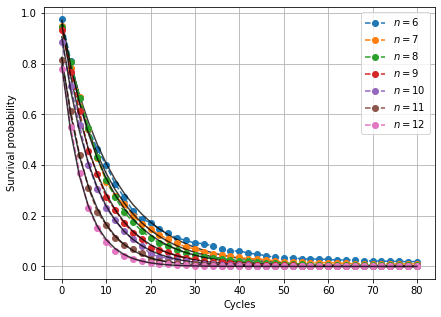

In [12]:
plt.figure(figsize=(7, 5))

for (i, p) in enumerate(avg_probs):
    plt.plot(cycle_values, p, "--o", label=f"$n = {len(lines[i])}$")
    plt.plot(
        cycle_values, 
        fit(cycle_values, opt_avals[i], opt_fvals[i]), 
        color="black", 
        alpha=0.75,
    )

plt.legend()
plt.ylabel("Survival probability")
plt.xlabel("Cycles")
plt.grid("on");

## Parallel XEB

Last, we run a parallel XEB experiment. For more background on this section, see the [parallel XEB tutorial](https://quantumai.google/cirq/qcvv/parallel_xeb).

In [13]:
"""Setup for parallel XEB experiment."""
from cirq.experiments import random_quantum_circuit_generation as rqcg
import cirq.contrib.routing as ccr

# Generate library of XEB circuits.
circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, 
    two_qubit_gate=cirq.ISWAP**0.5,
    random_state=52,
)
combs_by_layer = rqcg.get_random_combinations_for_device(
    n_library_circuits=len(circuit_library),
    n_combinations=10,
    device_graph=ccr.gridqubits_to_graph_device(sorted(all_qubits[-1])),
    random_state=53,
)
cycle_depths = np.arange(3, 100, 20)

In [14]:
"""Collect all data by executing circuits."""
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities, fit_exponential_decays

# Run XEB circuits on the processor.
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combs_by_layer,
    shuffle=np.random.RandomState(52),
)

# Run XEB circuits on a simulator and fit exponential decays.
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
)
fidelities = fit_exponential_decays(fids)

100%|██████████| 207/207 [04:34<00:00,  1.33s/it]


In [15]:
"""Grab (pair, fidelity) data for all qubit pairs."""
pxeb_results = {}

for (_, _, pair), fidelity in fidelities.layer_fid.items():
    pxeb_results[pair] = 1.0 - fidelity

pxeb_errors = []
for i in range(len(all_qubits[-1]) - 1):
    pair = (cirq.GridQubit(*line[i]), cirq.GridQubit(*line[i + 1]))

    if pair not in pxeb_results.keys():
        pair = pair[::-1]

    pxeb_errors.append(pxeb_results.get(pair))


pvals = [np.average(pxeb_errors[:len(l)]) for l in lines]

We can visualize these results on a `cirq.TwoQubitInteractionHeatmap` as follows.

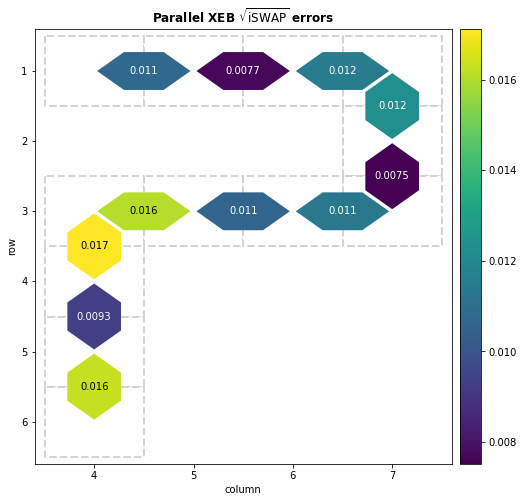

In [16]:
cirq.TwoQubitInteractionHeatmap(pxeb_results).plot(
    title=r"Parallel XEB $\sqrt{\rm{iSWAP}}$ errors"
);

## Comparing results

Finally, we plot the error rates for all benchmarks and compare to calibration.

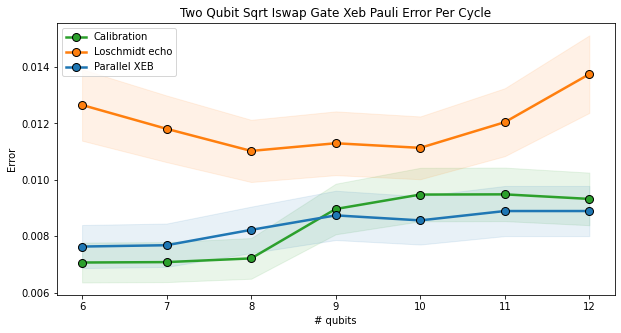

In [17]:
"""Compare calibration to Loschmidt to parallel XEB error rates."""
plt.figure(figsize=(10, 5))
width = 0.1

nvals = [len(l) for l in lines]
vals = (np.array(cvals), np.array(lvals) / (4 / 3), np.array(pvals) / (4 / 3))
colors = ("tab:green", "tab:orange", "tab:blue")
labels = ("Calibration", "Loschmidt echo", "Parallel XEB")

for i in range(len(labels)):
    plt.plot(
        nvals, vals[i], "-o", lw=2.5, markersize=8, markeredgecolor="black", 
        color=colors[i], label=labels[i]
    )
    plt.fill_between(
        nvals, (1.0 - width) * vals[i], (1.0 + width) * vals[i],
        alpha=0.1, color=colors[i],
    )

plt.xlabel("# qubits")
plt.title(metric.replace("_", " ").title())
plt.ylabel("Error")
plt.legend();

Note: The Loschmidt echo and parallel XEB errors are scaled in the previous cell. See the [XEB theory tutorial](https://quantumai.google/cirq/qcvv/xeb_theory) for an explanation why.